In [ ]:
import os    
import pandas as pd
import ollama
import chromadb
import re
import sqlite3

In [ ]:
client = chromadb.PersistentClient(path="full_data/")

In [ ]:
def retrieveID(paper_name, cursor):
    connection = sqlite3.connect("papers.db")
    cursor = connection.cursor()

    query = """
    SELECT paper_id FROM papers
    WHERE title = ?
    Limit 1
    """
    cursor.execute(query, (paper_name,))
    results = cursor.fetchall()
    
    #This returns paperID for use in future queries because working with a single ID is easier than working with title string
    return(results[0][0])

    #retrieveID("Intersection Theory, Integrable Hierarchies and Topological Field Theory") Example use case returns 9201003

In [113]:
def retrieveID_batch(paper_names, cursor):

    placeholders = ','.join(['?' for _ in paper_names])
    
    query = f"""
    SELECT title, paper_id FROM papers
    WHERE title IN ({placeholders})
    """

    cursor.execute(query, paper_names)
    results = cursor.fetchall()

    mp = {result[0]: result[1] for result in results}

    ids_list = [mp[name] for name in paper_names]

    return ids_list


In [ ]:
def get_similar_abstract(paper_id, cursor, limit=30):

    query = """
    SELECT abstract FROM papers
    WHERE paper_id = ?
    Limit 1
    """
    cursor.execute(query, (paper_id,))
    results = cursor.fetchall()
    #Retrieved abstract from relationalDB
    abstract = results[0][0]
    
    #Make Call to VectorDB; No clue if this works or not because once again my connection is being shot and stabbed
    #Instantiate Collection; using name = abstract change if named differently
    collection = client.get_or_create_collection(name="docs")
    
    response = ollama.embed(
      input=[abstract],
      model="mxbai-embed-large"
    )
    results = collection.query(
      query_embeddings=response["embeddings"],
      n_results=limit
    )

    #Data will have to be formatted by someone who can yk read the fucking data but just return list of ids
    data = results['ids'][0]
    return(data)

In [157]:
def get_similar_abstract_batch(paper_ids, cursor, limit=30):
    paper_ids_str = str(paper_ids).replace('[', '(').replace(']', ')')
    query = f"""
    SELECT paper_id,abstract FROM papers
    WHERE paper_id IN {paper_ids_str}
    """
    cursor.execute(query)
    results = cursor.fetchall()
    #Retrieved abstract from relationalDB
    mp = {}
    for result in results:
        mp[result[0]] = result[1]
    # abstract = results[0][0]
    abs_list = []
    for paper_id in paper_ids:
      abs_list.append(mp[paper_id])

    collection = client.get_or_create_collection(name="docs")
    
    response = ollama.embed(
      input=abs_list,
      model="mxbai-embed-large"
    )
    results = collection.query(
      query_embeddings=response["embeddings"],
      n_results=limit
    )
    data = results['ids']
    return data

In [ ]:
def get_similar_authors(paper_id, cursor,limit=30):

    query = """
    SELECT authors FROM papers
    WHERE paper_id = ?
    Limit 1
    """
    cursor.execute(query, (paper_id,))
    results = cursor.fetchall()
    author = results[0][0]
    
    collection = client.get_or_create_collection(name="authors")
    
    response = ollama.embed(
      input=author,
      model="mxbai-embed-large"
    )
    results = collection.query(
      query_embeddings=response["embeddings"],
      n_results=limit
    )

    data = results['ids'][0]
    return(data)

In [158]:
def get_similar_authors_batch(paper_ids, cursor,limit=30):
    paper_ids_str = str(paper_ids).replace('[', '(').replace(']', ')')
    query = f"""
    SELECT paper_id,authors FROM papers
    WHERE paper_id IN {paper_ids_str}
    """
    cursor.execute(query)
    results = cursor.fetchall()
    #Retrieved abstract from relationalDB
    mp = {}
    for result in results:
        mp[result[0]] = result[1]
    # abstract = results[0][0]
    author_list = []
    for id in paper_ids:
      author_list.append(mp[id])
    
    #Make Call to VectorDB; No clue if this works or not because once again my connection is being shot and stabbed
    #Instantiate Collection; using name = abstract change if named differently
    collection = client.get_or_create_collection(name="authors")
    
    response = ollama.embed(
      input=author_list,
      model="mxbai-embed-large"
    )
    results = collection.query(
      query_embeddings=response["embeddings"],
      n_results=limit
    )

    #Data will have to be formatted by someone who can yk read the fucking data but just return list of ids
    data = results['ids']
    return data

In [ ]:
def find_co_citations(paper_id, cursor, limit = 30):

    #This query returns top co-citations as a list of tuples [(paper_id, citation_count)] 
    # query = """
    # SELECT 
    #     CASE 
    #         WHEN paper_1_id = ? THEN paper_2_id
    #         ELSE paper_1_id 
    #     END AS co_cited_paper_id,
    #     co_citation_count
    # FROM co_citations
    # WHERE paper_1_id = ? OR paper_2_id = ?
    # ORDER BY co_citation_count DESC
    # """
    query = """
    SELECT 
        CASE 
            WHEN paper_1_id = ? THEN paper_2_id
            ELSE paper_1_id
        END AS co_cited_paper_id,
        co_citation_count,
        pd.publication_date
    FROM co_citations
    JOIN paper_dates pd 
        ON pd.paper_id = CASE 
            WHEN paper_1_id = ? THEN paper_2_id
            ELSE paper_1_id
        END
    WHERE paper_1_id = ? OR paper_2_id = ?
    ORDER BY co_citation_count DESC, 
             pd.publication_date DESC
    LIMIT ?
    """
    cursor.execute(query, (paper_id, paper_id, paper_id, paper_id, limit))
    top_co_citations = cursor.fetchall()
    paper_id_list = [x[0] for x in top_co_citations]
    return paper_id_list
    #Sample Input: 
    #find_co_citations(9201001)
    #Sample Output: ['9201013', '9302014', '9203009', '9201011', '9201033', '9203043',
    #'9208031', '9208046', '9302048', '9303139', '9304011', '9201003', '9202006', '9203030',
    #'9206090', '9307063', '9312210', '9505127', '9201010', '9207020']

In [ ]:
def find_co_citations_batch_optimized(paper_ids, cursor, limit=30):
    # Use VALUES to avoid a temporary table
    query = f"""
    WITH batch_inputs AS (
        VALUES {','.join(f'({paper_id}, {limit})' for paper_id in paper_ids)}
    ),
    RankedResults AS (
        SELECT 
            CASE 
                WHEN paper_1_id = bi.column1 THEN paper_2_id
                ELSE paper_1_id
            END AS co_cited_paper_id,
            co_citation_count,
            pd.publication_date,
            bi.column1 AS original_paper_id,
            ROW_NUMBER() OVER (
                PARTITION BY bi.column1 
                ORDER BY co_citation_count DESC, pd.publication_date DESC
            ) AS rank
        FROM co_citations
        JOIN paper_dates pd 
            ON pd.paper_id = CASE 
                WHEN paper_1_id = bi.column1 THEN paper_2_id
                ELSE paper_1_id
            END
        JOIN batch_inputs bi
            ON paper_1_id = bi.column1 OR paper_2_id = bi.column1
    )
    SELECT co_cited_paper_id, co_citation_count, publication_date, original_paper_id
    FROM RankedResults
    WHERE rank <= ?
    ORDER BY original_paper_id, rank
    """
    cursor.execute(query, (limit,))
    return cursor.fetchall()


In [145]:
def filter_recommendation(paper_ids, cursor):
    paper_ids = str(paper_ids).replace('[', '(').replace(']', ')')
    query = f"""
    SELECT paper_id  from papers
    WHERE paper_id in {paper_ids}
    ORDER BY citation_count DESC, submitted_date DESC
    LIMIT 10
    """
    cursor.execute(query)
    retList = cursor.fetchall()
    retList =[x[0] for x in retList]
    return retList

In [147]:
def reccPaper(paper_name, include_abs=True, include_auth=True, include_cite=True):
    connection = sqlite3.connect("papers.db")
    cursor = connection.cursor()
    paper_id = retrieveID(paper_name, cursor)
    
    
    combined_list = []
    if include_abs:
        abstract_id_list = get_similar_abstract(paper_id, cursor)
        combined_list += abstract_id_list
    if include_auth:
        author_id_list = get_similar_authors(paper_id, cursor)
        combined_list += author_id_list

    if include_cite:
        co_citation_list = find_co_citations(paper_id, cursor)
        combined_list += co_citation_list
    combined_list = [str(int(i)) for i in combined_list]
    final_recommendation_list = filter_recommendation(combined_list, cursor)
    score = evaluate(final_recommendation_list, cursor, paper_id)

    connection.commit()
    cursor.close()
    connection.close()
    
    return final_recommendation_list, score

In [159]:
def reccPaper_batch(paper_names):
    connection = sqlite3.connect("papers.db")
    cursor = connection.cursor()

    paper_ids = retrieveID_batch(paper_names, cursor)
    
    abstract_id_list = get_similar_abstract_batch(paper_ids, cursor)
    
    author_id_list = get_similar_authors_batch(paper_ids, cursor)

    co_citation_list = []
    
    for paper_id in paper_ids:
        co_citation_list.append(find_co_citations(paper_id, cursor))
    ans = []
    for i in range(len(abstract_id_list)):
        combined_list = abstract_id_list[i] + author_id_list[i] + co_citation_list[i]
    
        final_recommendation_list = filter_recommendation(combined_list, cursor)
        score = evaluate_multiple(final_recommendation_list, cursor, paper_ids)
        ans.append((final_recommendation_list,score))
    connection.commit()
    cursor.close()
    connection.close()
    
    return ans

In [ ]:
def evaluate(paper_ids, cursor, input_paper):
    paper_ids = str(paper_ids).replace('[', '(').replace(']', ')')
    query = f"""
    SELECT count(*)
    from papers p, citations c
    WHERE p.paper_id in {paper_ids}
    AND ((from_paper_id = p.paper_id AND to_paper_id = {input_paper}) OR (from_paper_id = {input_paper} AND to_paper_id = p.paper_id)) 
    """
    cursor.execute(query)
    retList = cursor.fetchall()
    cnt = retList[0][0]
    return cnt

In [ ]:
def evaluate_multiple(paper_ids, cursor, input_papers):
    paper_ids = str(paper_ids).replace('[', '(').replace(']', ')')
    input_papers = str(input_papers).replace('[', '(').replace(']', ')')
    query = f"""
    SELECT count(*)
    from papers p, citations c
    WHERE p.paper_id in {paper_ids}
    AND ((from_paper_id = p.paper_id AND to_paper_id in {input_papers}) OR (from_paper_id in {input_papers} AND to_paper_id = p.paper_id)) 
    """
    cursor.execute(query)
    retList = cursor.fetchall()
    cnt = retList[0][0]
    return cnt

In [ ]:
def combine_multiple(paper_list):
    final_results = {}
    for paper in paper_list:
        results = reccPaper(paper)
        for rec in results:
            if rec not in final_results:
                final_results[rec] = 0
            final_results[rec] += 1
    
    ls = []
    for rec in final_results:
        ls.append((final_results[rec],rec))
    
    ls.sort()
    return ls[-10:]




In [ ]:
def find_co_citations_batch(paper_ids, cursor, limit = 30):

    #This query returns top co-citations as a list of tuples [(paper_id, citation_count)] 
    # query = """
    # SELECT 
    #     CASE 
    #         WHEN paper_1_id = ? THEN paper_2_id
    #         ELSE paper_1_id 
    #     END AS co_cited_paper_id,
    #     co_citation_count
    # FROM co_citations
    # WHERE paper_1_id = ? OR paper_2_id = ?
    # ORDER BY co_citation_count DESC
    # """
    query = """
    SELECT 
        CASE 
            WHEN paper_1_id = ? THEN paper_2_id
            ELSE paper_1_id
        END AS co_cited_paper_id,
        co_citation_count,
        pd.publication_date
    FROM co_citations
    JOIN paper_dates pd 
        ON pd.paper_id = CASE 
            WHEN paper_1_id = ? THEN paper_2_id
            ELSE paper_1_id
        END
    WHERE paper_1_id = ? OR paper_2_id = ?
    ORDER BY co_citation_count DESC, 
             pd.publication_date DESC
    LIMIT ?
    """
    query_list = []
    for paper_id in paper_ids:
        query_list.append((paper_id,paper_id,paper_id,paper_id,limit))
    cursor.executemany(query,query_list)
    # cursor.execute(query, (paper_id, paper_id, paper_id, paper_id, limit))
    top_co_citations = cursor.fetchall()
    paper_id_list = [x[0] for x in top_co_citations]
    return paper_id_list
    #Sample Input: 
    #find_co_citations(9201001)
    #Sample Output: ['9201013', '9302014', '9203009', '9201011', '9201033', '9203043',
    #'9208031', '9208046', '9302048', '9303139', '9304011', '9201003', '9202006', '9203030',
    #'9206090', '9307063', '9312210', '9505127', '9201010', '9207020']

In [164]:
for i in test:
    reccPaper(i)

In [ ]:
import time
unbatch = []
batch = []
# input_sizes = [100, 500, 1000, 5000]
input_sizes[10,100]
for input_size in input_sizes:
    test = random.sample(titles, input_size)
    start = time.time()
    for i in test:
        reccPaper(i)
    unbatch.append(time.time()-start)

    start = time.time()
    reccPaper_batch(test)
    batch.append(time.time()-start)   

In [165]:
reccPaper_batch(test)

[(['202021',
   '9507121',
   '112044',
   '201081',
   '110242',
   '202109',
   '9603127',
   '202111',
   '202179',
   '101029'],
  4),
 (['9507121',
   '9612128',
   '9611213',
   '9503086',
   '9405124',
   '9902074',
   '9401125',
   '9812093',
   '9608186',
   '9304005'],
  3),
 (['9507121',
   '9503086',
   '9405124',
   '9902074',
   '9401125',
   '9812093',
   '9708099',
   '9910194',
   '9703077',
   '9903067'],
  2),
 (['9507121',
   '9603127',
   '9503086',
   '9405124',
   '9902074',
   '9712073',
   '9812093',
   '9608186',
   '9708099',
   '9607145'],
  5),
 (['9507121',
   '9503086',
   '9405124',
   '9902074',
   '9412229',
   '9401125',
   '9812093',
   '9303005',
   '9708099',
   '9903130'],
  5),
 (['9510209',
   '9507121',
   '9905012',
   '9910219',
   '9803235',
   '9911055',
   '103239',
   '9912287',
   '9503086',
   '9405124'],
  8),
 (['9507121',
   '9503086',
   '9405124',
   '9902074',
   '9401125',
   '9812093',
   '9708099',
   '9910194',
   '9703077',
 

In [ ]:
connection = sqlite3.connect("papers.db")
cursor = connection.cursor()

query = 'delete from reading_list'
cursor.execute(query)
connection.commit()

In [ ]:
query = 'select title from papers where authors IS NULL LIMIT 1'
cursor.execute(query)
# print(len(cursor.fetchall()))
for i in cursor.fetchall():
    print(i[0])

Evaluation

In [101]:
connection = sqlite3.connect("papers.db")
cursor = connection.cursor()

query = 'select title from papers where authors is not null and abstract is not null'
cursor.execute(query)
titles = [i[0] for i in cursor.fetchall()]

In [123]:
import random
random.seed(42)

test = random.sample(titles, 100)


In [ ]:
prec = []
for title in test:
    res = reccPaper(title)
    prec.append(res[1]/len(res[0]))

(array([46., 12.,  1., 11.,  0., 15.,  0.,  9.,  0.,  6.]),
 array([0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
        0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ,
        0.55555556]),
 <BarContainer object of 10 artists>)

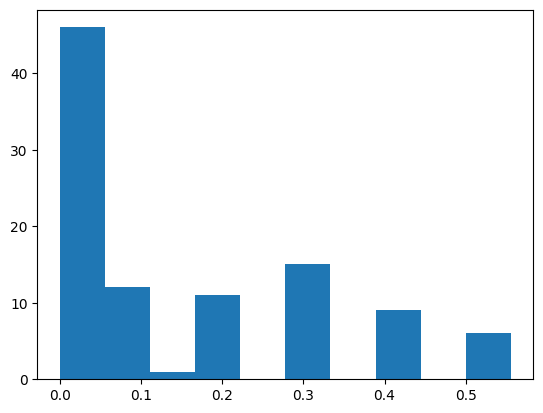

In [107]:
import matplotlib.pyplot as plt
plt.hist(prec,bins=10)

Abstract + Co-citations

In [ ]:
prec = []
for title in test:
    res = reccPaper(title, include_auth=False)
    prec.append(res[1]/len(res[0]))
plt.hist(prec,bins=10)

In [156]:
recc_paper_batch(test[:5])

{'ids': [['9708099', '0103162', '9902074', '9910194', '0102130', '9912288', '0211139', '0003275', '9806082', '9712142', '0001107', '9806175', '0003256', '0009117', '0003162', '9907024', '0107254', '0106058', '9402086', '0012216', '0008001', '9812093', '9709063', '9704127', '9405124', '0110036', '9801120', '0102145', '9906216', '9912276'], ['9708099', '0103162', '9902074', '9910194', '9912288', '0102130', '0003275', '0001107', '0003162', '0009117', '0003256', '0107254', '9907024', '0106058', '9402086', '0012216', '9812093', '0008001', '9201042', '0009249', '9906216', '0102145', '9912276', '0105224', '9405124', '9508108', '9911193', '9709066', '0005230', '9712159'], ['9708099', '9902074', '0103162', '0008129', '9910194', '0102130', '9912288', '0003275', '0205299', '0009117', '9402086', '0001107', '9907024', '0003256', '0003162', '0107254', '0012216', '0008001', '0106058', '0210130', '9906216', '9812093', '9911193', '9903015', '9906008', '0102145', '9405124', '0105224', '9912276', '000523

(['202021',
  '9507121',
  '112044',
  '201081',
  '110242',
  '202109',
  '9612128',
  '9603127',
  '202111',
  '9611213'],
 0)

(array([98.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 <BarContainer object of 10 artists>)

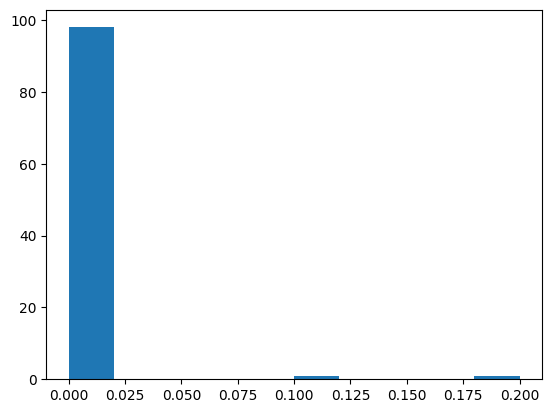

In [ ]:
prec = []
for title in test:
    res = reccPaper(title, include_auth=False, include_cite=False)
    if len(res[0]) == 0:
        prec.append(0)
    else:
        prec.append(res[1]/len(res[0]))
plt.hist(prec,bins=10)
plt.title("Histogram of precision")

Text(0.5, 1.0, 'Histogram of precision')

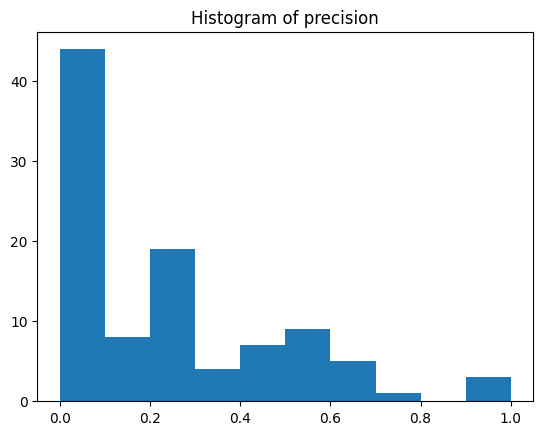

In [150]:
prec = []
for title in test:
    res = reccPaper(title, include_abs=False, include_auth=False)
    if len(res[0]) == 0:
        prec.append(0)
    else:
        prec.append(res[1]/len(res[0]))
plt.hist(prec,bins=10)
plt.title("Histogram of precision")